In [1]:
import numpy as np
import astropy
from astropy.io import ascii
from astropy.table import Table
import scipy.linalg as la
import pandas as pd
import requests
import uncertainties
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
import json
import os
from scipy.optimize import curve_fit
import time


In [2]:
from uncertainties import unumpy as unp


In [3]:
from matplotlib import rc
# Default properties:
# rc('text', usetex=True)
rc('font', family='serif')
#rc('font', serif='palatino')
#rc('font', weight='bolder')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=2)
rc("lines", linewidth=3)
rc('axes', labelsize=30)
rc("axes", linewidth=2)
rc('xtick', labelsize=28)
rc('ytick', labelsize=28)
rc('legend', fontsize=20)
rc('xtick.major', pad=8)
rc('ytick.major', pad=8)
rc('xtick.major', size=13)
rc('ytick.major', size=13)
rc('xtick.major', width=3)
rc('ytick.major', width=3)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)
rc('xtick.minor', width=3)
rc('ytick.minor', width=3)


In [4]:
header = ["Exclusion Code",
          "D",
          "G",
          "Galaxy ID",
          "m-M",
          "err",
          "D (Mpc)",
          "Method",
          "REFCODE",
          "SN ID",
          "redshift (z)",
          "Hubble const.",
          "Adopted LMC modulus",
          "Date (Yr. - 1980)",
          "Notes"]
ned_data = pd.read_csv("./NED30.5.1-D-17.1.2-20200415.csv",
                       names=header, skiprows=13)


In [5]:
def getGalInfo(galname):
    # res_headers = {
    #     'Content-type': 'application/json',
    # }
    res_data = {
        'json': '{"name":{"v": "%s"}}' % galname
    }
    res = requests.post(
        'https://ned.ipac.caltech.edu/srs/ObjectLookup', data=res_data)
    return res.json()


In [6]:
def mod2dist(distance_modulus):
    return 10**(distance_modulus / 5)*10 / 1e6  # in unit Mpc


In [7]:
trgb_method = ned_data[ned_data["Method"] == "TRGB"]


In [8]:
if not os.path.exists('./trgb_reshift.json'):
    trgb_host_info = {}
    for index, row in trgb_method.iterrows():
        try:
            gal_info = getGalInfo(row["Galaxy ID"])["Preferred"]
        except:
            print(row["Galaxy ID"], "no data")
            continue
        redshift = gal_info["Redshift"]["Value"]
        z_err = gal_info["Redshift"]["Uncertainty"]
        paper_reference = gal_info["Redshift"]["RefCode"]
        if redshift is None:
            print(row["Galaxy ID"], " redshift is null")
            continue
        trgb_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)
        time.sleep(1)
    with open("trgb_reshift.json", "w") as fout:
        json.dump(trgb_host_info, fout)
else:
    with open("./trgb_reshift.json", "r") as fread:
        trgb_host_info = json.load(fread)


In [9]:
# plt.figure(figsize=(8, 6))
trgb_d = []
trgb_vr = []
trgb_err_vr = []
trgb_err_d = []
max_paper = None
max_num = 0
for paper in trgb_method['REFCODE']:
    if max_num < sum(trgb_method['REFCODE'] == paper):
        max_num = sum(trgb_method['REFCODE'] == paper)
        max_paper = paper
trgb_method_paper = trgb_method[trgb_method['REFCODE'] == max_paper]
# print(max)
for index, row in trgb_method_paper.iterrows():
    # print(bh_host_info[row["Galaxy ID"]][0])
    # if 3.35 < row["D (Mpc)"] and  row["D (Mpc)"] < 3.8:
    #     continue
    if row["Galaxy ID"] not in trgb_host_info.keys():
        # print("not plot %s" % row["Galaxy ID"])
        continue
    # 3 sigma cut
    if trgb_host_info[row["Galaxy ID"]][0] < 3 * trgb_host_info[row["Galaxy ID"]][1]:
        # print(index, row["Galaxy ID"], "rejected by 3 sigma cut")
        continue
    # if row["D (Mpc)"] < 10 and (const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0]).value > 3000:
        # print(row)
        # print(trgb_host_info[row["Galaxy ID"]][0], trgb_host_info[row["Galaxy ID"]][1], trgb_host_info[row["Galaxy ID"]][2])
    u_dist = mod2dist(unp.uarray(row["m-M"], row["err"]))
    trgb_d.append(u_dist.n)
    trgb_err_d.append(u_dist.s)
    trgb_vr.append(const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0])
    trgb_err_vr.append(const.c.to(u.km/u.s) *
                       trgb_host_info[row["Galaxy ID"]][1])
trgb_d = np.array(trgb_d)
trgb_err_d = np.array(trgb_err_d)
trgb_vr = np.array([i.value for i in trgb_vr])
trgb_err_vr = np.array([i.value for i in trgb_err_vr])
# plt.ylim([0, 2e3])


In [11]:
def hubble(d, H0):
    return H0 * d


[63.18555585] [[5.29506486]]


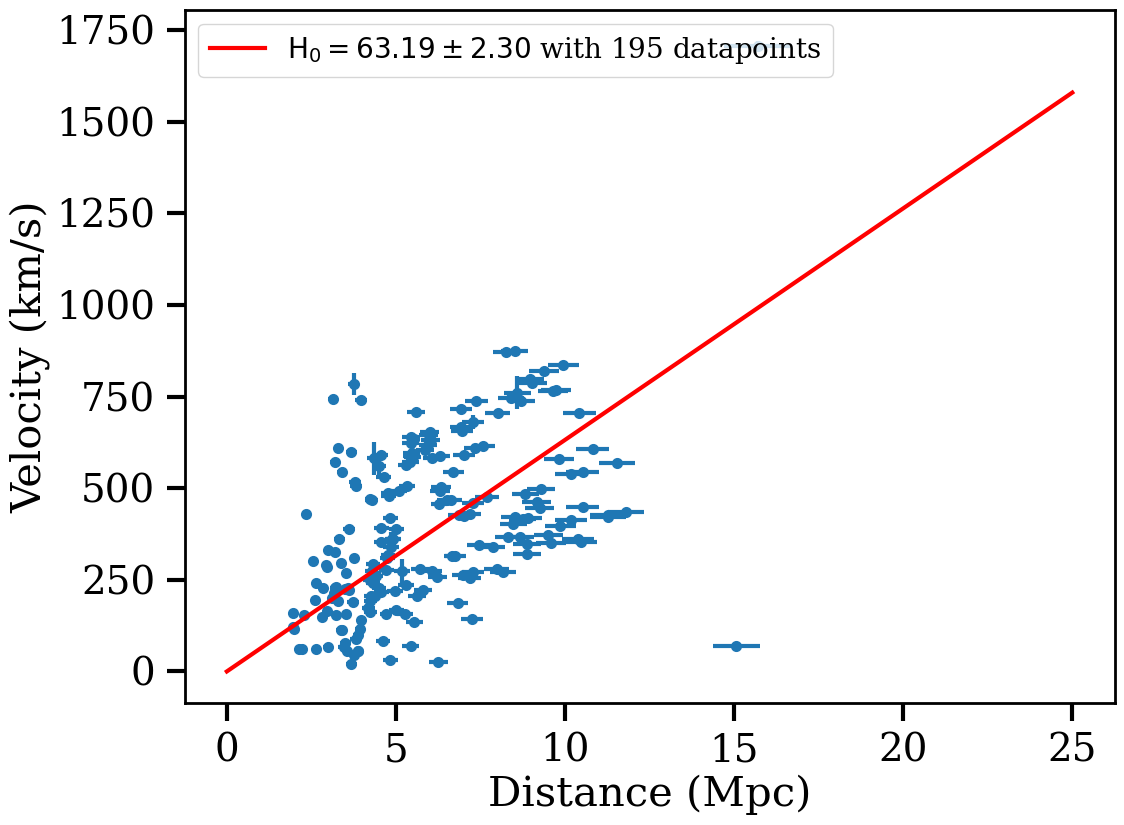

In [91]:
remove_value = (0 < trgb_d) & (trgb_d < 5) & (trgb_vr > 1.5e3)
dist_cut = (trgb_d > 3 * trgb_err_d)
z_cut = (trgb_vr > 3 * trgb_err_vr)
mask = (trgb_d > 1.5) & ~remove_value & dist_cut & z_cut
trgb_popt, trgb_pcov = curve_fit(hubble, trgb_d[mask], trgb_vr[mask])
print(trgb_popt, trgb_pcov)
plt.figure(figsize=(12, 9))
plt.errorbar(trgb_d[mask], trgb_vr[mask], fmt='o',
             yerr=trgb_err_vr[mask], xerr=trgb_err_d[mask])
xarr = np.linspace(0, 25)
plt.plot(xarr, trgb_popt * xarr, "r", label=r"$H_0=%.2f \pm %.2f$ with %s datapoints" %
         (trgb_popt, np.sqrt(trgb_pcov), sum(mask)), zorder=1e10)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km/s)")
plt.legend(loc="upper left")
# plt.xlim([0, 450])
# plt.ylim([0, 3000])
plt.show()
# plt.savefig("trbg_single_paper.pdf", bbox_inches="tight")


In [13]:
from hyperfit.linfit import LinFit

In [92]:
trgb_data, trgb_cov = np.empty((2, trgb_d[mask].shape[0])), np.empty((2, 2, trgb_d[mask].shape[0]))
for i, (x, y, ex, ey) in enumerate(zip(trgb_d[mask], trgb_vr[mask], trgb_err_d[mask], trgb_err_vr[mask])):
    trgb_data[:, i] = np.array([x, y])
    trgb_cov[:, :, i] = np.array([[ex**2, 0], [0, ey**2]])
# trgb_data = np.array([trgb_d[mask], trgb_vr[mask]])
# trgb_cov = np.array([[[trgb_err_d[mask][i]**2, 0], [0, trgb_err_vr[mask][i]**2]] for i in range(len(trgb_d[mask]))]).T

In [102]:
hf = LinFit(trgb_data, trgb_cov)  

In [118]:
bounds = ((-1e-2, 100), (-1e-2, 3000), (1e-5, 5.0))
hf.optimize(bounds=bounds)

(array([79.45916056, -0.39732195]), 227.22799073852988, -303.3161943307514)

In [119]:
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: array([303.31619868])
     jac: array([-3.38677523e+01,  3.98008183e+01,  3.10137695e-02])
 message: 'Optimization terminated successfully.'
    nfev: 5518
     nit: 121
 success: True
       x: array([ 4.99988886e-03, -6.29276186e-05,  2.84163503e+00])


  0%|          | 0/1000 [00:00<?, ?it/s]/home/brook/anaconda3/envs/py39/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:00<00:00, 1432.85it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [78.8482535  78.42214226 33.18766307] / 3942.4126748084277


100%|██████████| 1000/1000 [00:00<00:00, 1351.64it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.79206444 52.17209021 38.01269603] / 2608.6045106984857


100%|██████████| 1000/1000 [00:00<00:00, 1440.40it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [53.44060964 53.58824996 42.81740276] / 2679.4124980299866


100%|██████████| 1000/1000 [00:00<00:00, 1543.30it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.95407467 57.86571717 46.29970534] / 2897.7037336119806


100%|██████████| 1000/1000 [00:00<00:00, 1601.26it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.07791719 57.39775107 49.74893184] / 2869.8875535727607


100%|██████████| 1000/1000 [00:00<00:00, 1464.88it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [51.20836419 50.98392466 47.54585973] / 2560.418209464786


100%|██████████| 1000/1000 [00:00<00:00, 1514.76it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [55.46449464 55.59010346 44.34074795] / 2779.505173205747


100%|██████████| 1000/1000 [00:00<00:00, 1482.03it/s]


Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [57.87272906 58.00816572 45.03599006] / 2900.408285824847
[ 78.52586454   6.99860657 227.00679564] [ 2.94360817  4.97810646 14.43249519]


In [58]:
trgb_d[mask]

array([ 8.7096359 ,  6.22300285,  3.20626932,  6.6374307 ,  4.89778819,
        1.95884467,  1.99526231,  6.82338694,  7.17794291,  4.92039536,
        4.69894109,  6.08135001,  7.01455298,  4.5708819 ,  8.66961876,
        7.44731974,  7.17794291,  5.27229861,  5.62341325,  5.01187234,
        6.02559586,  4.24619564,  7.27779805,  2.97851643,  5.52077439,
        6.95024318,  6.69884609,  9.03649474,  9.63829024,  8.39459987,
        6.08135001,  6.30957344,  6.33869711,  9.37562007, 10.18591388,
        5.29663444, 11.27197456, 11.80320636,  6.66806769, 10.47128548,
        4.6344692 ,  3.16227766, 10.37528416,  8.16582371,  7.97994687,
        9.24698174,  9.59400632,  7.8704579 ,  9.86279486,  8.24138115,
        4.38530698,  8.59013522,  8.47227414,  9.1622049 ,  8.830799  ,
        9.28966387,  4.2854852 ,  3.98107171, 10.18591388, 11.53453258,
        7.6913044 ,  8.87156012, 10.51961874, 10.51961874, 10.42317429,
        6.91830971,  9.81747943,  6.91830971,  3.94457302,  5.47

In [60]:
trgb_vr[mask]

array([  737.18965422,   258.        ,   226.94289071,   467.07664657,
         361.84949381,   158.89000844,   116.91905892,   187.37028205,
         256.02275434,   360.95011943,   155.89207816,   273.99999999,
         423.00716723,   390.92936523,   366.04658522,   345.06112815,
         429.0030074 ,   155.89207816,   206.55700596,   167.88378098,
         630.76333163,   470.07457414,   681.12848556,    66.85371813,
         633.1616713 ,   657.14506794,   544.42310373,   786.95519026,
         765.37014527,   747.08280534,   583.09633081,   492.25923103,
         504.25091436,   821.13151248,   411.91483729,   564.00000002,
         421.50819595,   435.89823393,   314.78206891,   354.05490189,
         530.03306574,   213.00000001,   360.65032697,   271.91175941,
         278.80697994,   444.89200767,   350.99999996,   340.86402475,
         396.02583702,   872.99565269, 18269.05232825,   759.97388103,
         402.6274768 ,   462.87955515,   483.26545729,   497.65546529,
      

In [33]:
trgb_data.shape

(2, 171)

In [28]:
cov.shape

(2, 2, 100)

In [31]:
trgb_cov = np.array([[[trgb_err_d[mask][i]**2, 0], [0, trgb_err_vr[mask][i]**2]] for i in range(len(trgb_d[mask]))]).T

In [32]:
trgb_cov.shape

(2, 2, 171)